<a href="https://colab.research.google.com/github/M-Kamalakannan/image-classification/blob/main/final_dl_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name  : M kamalakannan
class : 2nd-M.sc Data Analytics
Reg No: 23CSEG09

**Data preprocessing**

In [1]:
#connect drive
from google.colab import drive
drive.mount('/content/drive')
#clone github
!git clone https://github.com/shivansh-kaushal/Helmet-Non-Helmet-dataset-zip-files.git

Mounted at /content/drive
Cloning into 'Helmet-Non-Helmet-dataset-zip-files'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 33.92 MiB | 27.81 MiB/s, done.


In [2]:
import zipfile
import os

# Paths to the zip files
helmet_zip_path = '/content/Helmet-Non-Helmet-dataset-zip-files/Helmet_.zip'
non_helmet_zip_path = '/content/Helmet-Non-Helmet-dataset-zip-files/nohelmet.zip'

In [3]:
# show in colab content
with zipfile.ZipFile(helmet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/helmet')

with zipfile.ZipFile(non_helmet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/non_helmet')

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define paths
helmet_path = '/content/helmet'
non_helmet_path = '/content/non_helmet'
cleaned_helmet_path = '/content/cleaned_helmet'
cleaned_non_helmet_path = '/content/cleaned_non_helmet'

# Create directories for cleaned imag
os.makedirs(cleaned_helmet_path, exist_ok=True)
os.makedirs(cleaned_non_helmet_path, exist_ok=True)


In [11]:
#normalize and rename
def normalize_and_rename_images(source_dir, dest_dir, label):
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            # Read image
            img_path = os.path.join(source_dir, filename)
            img = cv2.imread(img_path)

            # Convert to JPG if necessary
            if filename.lower().endswith('.jpeg'):
                filename = filename.replace('.jpeg', '.jpg')

            # Resize image to 128x128
            img = cv2.resize(img, (128, 128))

            # Save the image in the destination directory
            dest_img_path = os.path.join(dest_dir, filename)
            cv2.imwrite(dest_img_path, img)

# Normalize and rename images
normalize_and_rename_images(helmet_path, cleaned_helmet_path, 'helmet')
normalize_and_rename_images(non_helmet_path, cleaned_non_helmet_path, 'non_helmet')

In [12]:
# Load images and labels
def load_images_and_labels(helmet_dir, non_helmet_dir):
    images = []
    labels = []

    # Load helmet images
    for filename in os.listdir(helmet_dir):
        img_path = os.path.join(helmet_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
        labels.append(0)  # Helmet label

    # Load non-helmet images
    for filename in os.listdir(non_helmet_dir):
        img_path = os.path.join(non_helmet_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
        labels.append(1)  # Non-helmet label

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(cleaned_helmet_path, cleaned_non_helmet_path)

**Train and test data split**

In [13]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [20]:
def count_labels(dataset):
    label_counts = {0: 0, 1: 0}
    for images, labels in dataset:
        unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
        for label, count in zip(unique_labels, counts):
            label_counts[label] += count
    return label_counts

train_label_counts = count_labels(train_dataset)
test_label_counts = count_labels(test_dataset)

print(f"Training label counts: {train_label_counts}")
print(f"Testing label counts: {test_label_counts}")


Training label counts: {0: 125, 1: 127}
Testing label counts: {0: 32, 1: 31}


Training Dataset Samples:


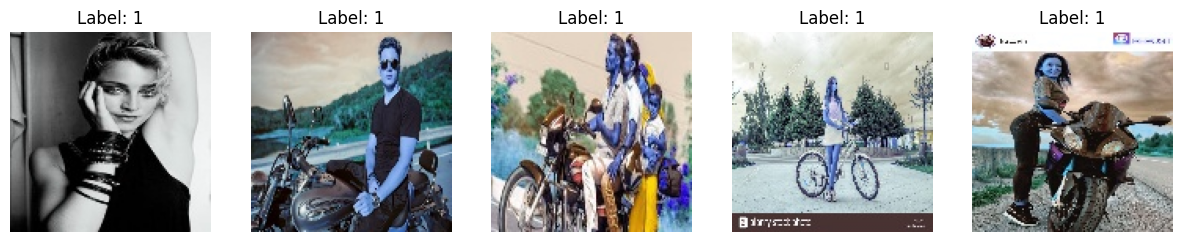

Testing Dataset Samples:


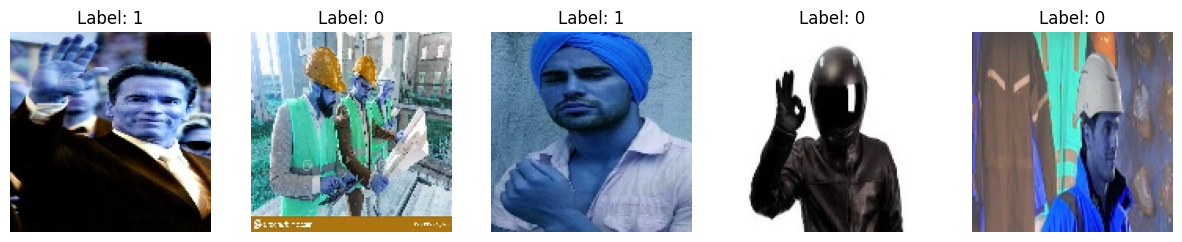

In [15]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(min(num_samples, len(images))):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f'Label: {labels[i].numpy()}')
            plt.axis('off')
        plt.show()
        break  # Only take one batch

# Visualize samples from the training dataset
print("Training Dataset Samples:")
visualize_dataset(train_dataset, num_samples=5)

# Visualize samples from the testing dataset
print("Testing Dataset Samples:")
visualize_dataset(test_dataset, num_samples=5)


**Model training**

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])


In [44]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [45]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=22
)


Epoch 1/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4351 - loss: 1.0313 - val_accuracy: 0.5714 - val_loss: 0.6908
Epoch 2/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5433 - loss: 0.6928 - val_accuracy: 0.5714 - val_loss: 0.6907
Epoch 3/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5806 - loss: 0.6886 - val_accuracy: 0.4921 - val_loss: 0.6926
Epoch 4/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4872 - loss: 0.6904 - val_accuracy: 0.4921 - val_loss: 0.6939
Epoch 5/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5109 - loss: 0.6778 - val_accuracy: 0.5238 - val_loss: 0.9133
Epoch 6/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6678 - loss: 0.5847 - val_accuracy: 0.5079 - val_loss: 0.6903
Epoch 7/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5569 - loss: 0.6785 - val_accuracy: 0.6032 - val_loss: 0.6730
Epoch 8/22
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6720 - loss: 0.6187 - val_accuracy: 0.5873 - val_loss: 0.6644
Epoch 9/

**Model Evaluation**

In [46]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - accuracy: 0.5686 - loss: 1.9604
Test Loss: 2.2395267486572266
Test Accuracy: 0.5873016119003296


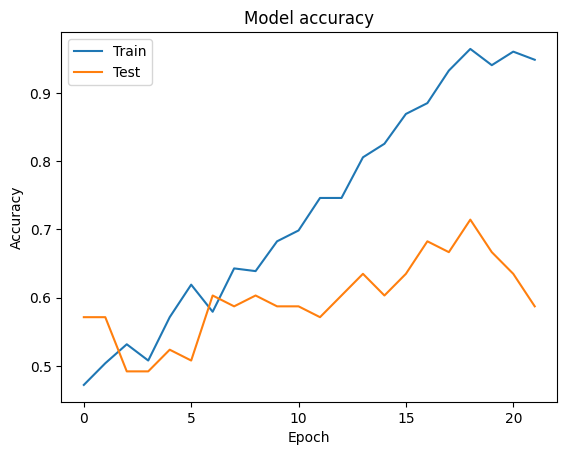

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



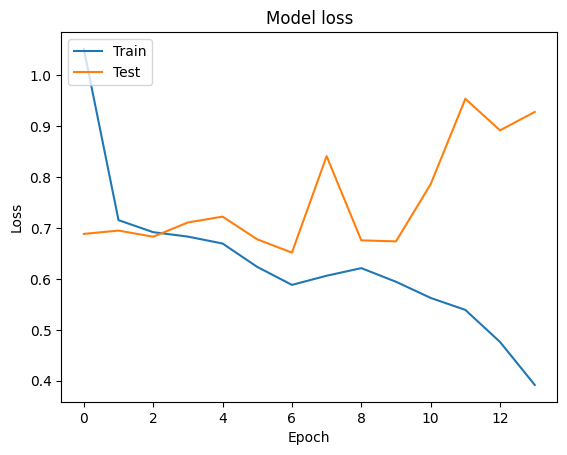

In [42]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model
y_true = []
y_pred = []

# Collect true labels and predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Helmet', 'No Helmet']))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

      Helmet       0.61      0.53      0.57        32
   No Helmet       0.57      0.65      0.61        31

    accuracy                           0.59        63
   macro avg       0.59      0.59      0.59        63
weighted avg       0.59      0.59      0.59        63

Confusion Matrix:
[[17 15]
 [11 20]]


In [52]:
# Save the entire model
model.save('/content/helmet_classifier_model.h5')  # This creates a single file




**Model for future prediction**

In [56]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the model (adjust the path to where your model is saved)
loaded_model = tf.keras.models.load_model('/content/helmet_classifier_model.h5')

In [58]:
from google.colab import files
from io import BytesIO
from PIL import Image as PILImage



# Upload image file
uploaded = files.upload()

# Get the uploaded image
for img_name in uploaded.keys():
    # Open and preprocess the image
    img = PILImage.open(BytesIO(uploaded[img_name]))
    img = img.resize((128, 128))  # Adjust size to match your model input
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if required

    # Make a prediction
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)  # Assuming classification task

    # Output the result
    class_names = ['Helmet', 'No Helmet']  # Adjust if you have different labels
    print(f'Predicted class for {img_name}: {class_names[predicted_class[0]]}')

Saving image.jpeg to image.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted class for image.jpeg: Helmet


**Disadvantage:**
using object detection detect helmet and train to increase the accuracy (future works)